In [1]:
import numpy as np

def onedim_8sites_IsingModel_OBC(qc,n_qubits,dt):
    
    odd=[0,2,4,6]
    even=[1,3,5]
    for i in range(n_qubits):
        qc.rz(-2*ht*dt,i) #qc.rz(-2 * theta, i)  # Implements e^{i θ Z} to the qubit i
    qc.barrier()
    for i in odd:
        qc.cx(i,i+1)
    for i in odd:
        qc.rx(-2*J*dt,i)
    for i in odd:
        qc.cx(i,i+1)
    qc.barrier()
    for i in even:
        qc.cx(i,i+1)
    for i in even:
        qc.rx(-2*J*dt,i)
    for i in even:
        qc.cx(i,i+1)
    qc.barrier()      


In [2]:
from qiskit import QuantumCircuit, QuantumRegister 
from qiskit.quantum_info import Statevector


J=0.02
ht=1
dt=10
time_steps=49
n_qubits=8
qr=QuantumRegister(n_qubits)
qc=QuantumCircuit(qr)
target_qubit=4




In [3]:
"""
NumPy Simulation Data:
"""
from qiskit_aer.noise import pauli_error, NoiseModel

pI1 = 1 - 2*0.00002 - 0.00006# probability of no error
p1 = [pI1, 0.00002, 0.00002, 0.00006]   #Optimistic error rates for current trapped ions for 1-qubit error
pI2 = 1 - 3*0.00033 
p2 = [pI2, 0.00033, 0.00033, 0.00033]   #Optimistic error rates for near-term superconducting qubits for 2-qubit error
p_meas = 0.05
# QuantumError objects
error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
error_table2 = pauli_error([("X", p1[1]), ("Y", p1[2]),("Z", p1[3]),("I", p1[0])])
error_gate2 = pauli_error([("X", p2[1]), ("Y", p2[2]),("Z", p2[3]),("I", p2[0])])
error_table3 = error_gate2.tensor(error_gate2)
 
# Add errors to noise model
noise = NoiseModel()

noise.add_all_qubit_quantum_error(error_meas, "measure")
noise.add_all_qubit_quantum_error(error_table2, ["u1", "u2", "u3","x", "sx", "rz"])
noise.add_all_qubit_quantum_error(error_table3, ["cx"])
 
print(noise)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['x', 'measure', 'u3', 'rz', 'u1', 'cx', 'sx', 'u2']
  All-qubits errors: ['measure', 'u1', 'u2', 'u3', 'x', 'sx', 'rz', 'cx']


In [ ]:
#ST approximation 

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Single-pass evolution circuit 
def one_step_circuit(nq, dt):
    qc_step = QuantumCircuit(nq)
    onedim_8sites_IsingModel_OBC(qc_step, nq, dt)  # <- tu unidad de evolución
    return qc_step

# Inicial state |00000001> 
sv = Statevector.from_label("00000001")

probs = []
amps_per_t = []  #save complete amplitudes at each t

for t in range(time_steps):
        # probability that the qubit ‘target_qubit’ is in |1> (marginal)
    p = 0.0
    for idx, amp in enumerate(sv.data):
        bitstring = format(idx, f"0{n_qubits}b")  # |x>
        if bitstring[::-1][target_qubit-1] == '1':  # little-endian for qubits
            p += float(np.abs(amp)**2)
    probs.append(p)
    # apply 1 step
    qc_step = one_step_circuit(n_qubits, dt)
    sv = sv.evolve(qc_step)

    # exact amplitudes in this step
    amps_per_t.append(sv.data.copy())   # np.ndarray length complex 2**n_qubits



In [ ]:
#NumPy (Noise) implementation 

from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


shots = 10000
probs_noise = [] #Probability list for site 3 that is in |1> (occupation value) as a function of Jt. That is: [occup.value(Jdt), occup.value(J2dt), ..., occup.value(Jdt*time_steps)]

for t in range(time_steps):   # we start at t=1
    counts_site4 = 0    
# Create circuit from scratch and initialize
    qc_t = QuantumCircuit(n_qubits)
    qc_t.x(n_qubits - 1)
# Apply the evolution t times
    for _ in range(t):
        onedim_8sites_IsingModel_OBC(qc_t, n_qubits, dt)
    qc_t.measure_all()
# Measure target_qubit with measurement noise
    sim_noise = AerSimulator(noise_model=noise, shots = shots)
# Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(
        optimization_level=3, backend=sim_noise
    )
    qc_t_noise = passmanager.run(qc_t)
            
# Run and get counts
    result_noise = sim_noise.run(qc_t_noise).result()
    counts_noise = result_noise.get_counts()
        
    # Count how many times qubit 3 is in |1>
    for bitstring, freq in counts_noise.items():
        if bitstring[-(target_qubit+1)] == "1":  # position of qubit 3
            counts_site4 += freq
# Save empirical probability of obtaining “1”
    prob_site4_noise = counts_site4 / shots
    probs_noise.append(prob_site4_noise)



In [6]:
#ibm_torino values
time_steps_ibm = np.array([0,8,16,24,32,40,48])
x_vals_ibm = time_steps_ibm * J * dt

prob_ibm = [0.0026,0.2136,0.1626,0.1684,0.2375,0.3692,0.2844]

In [ ]:
#Exact diagonalization

# Upload CSV (no header, delimiter ;, convert comma->period)
data = np.loadtxt(
    r"C:\Users\pablo\OneDrive\Escritorio\Universidad\TFG\\Default Dataset for Exact Results\Default Dataset (9).csv",
    delimiter=";",
    converters={
        0: lambda s: float(s.replace(",", ".")),
        1: lambda s: float(s.replace(",", "."))
    }
)

# Separate columns
x_exact = data[:,0]
y_exact = data[:,1]

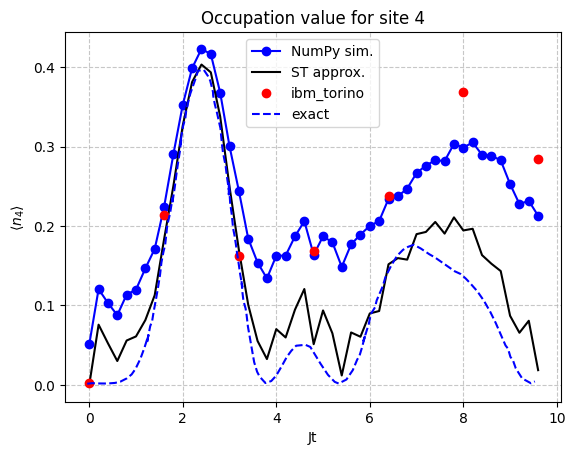

In [ ]:
import matplotlib.pyplot as plt

x_vals=np.arange(time_steps)*J*dt
plt.plot(x_vals, probs_noise, 'o-', color='blue', label='NumPy sim.')
plt.plot(x_vals, probs, '-', color='black', label='ST approx.')
plt.plot(x_vals_ibm, prob_ibm, 'o', color='red', label='ibm_torino')
plt.plot(x_exact, y_exact, linestyle="--", color='blue',label='exact')
plt.xlabel("Jt")
plt.ylabel(fr"$\langle n_{{{target_qubit}}} \rangle$")
plt.title(f"Occupation value for site {target_qubit}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Encontrar la posición del máximo
idx_max = np.argmax(probs)   # índice del máximo
x_max = x_vals[idx_max]       # coordenada x del máximo
y_max = probs[idx_max]       # coordenada y del máximo
#plt.axvline(x=x_max, color="black", linestyle="--", label=f"máximo en x={x_max:.2f}")


plt.show()